In [1]:
from main import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%%time 
#Fitting for Model 1: (without CD) #using curve_fit
fit = Fitting('KMC_NonDynamic_Data_iCovg_iRates.csv','Atomic.csv','Stoich.csv','Param.csv',Input_Type='iCovg_iRates') #covgdep = Allowing for coverage dependance to be considered in the fit
fit.set_rxnconditions() #Sets the Pressures and Temperature as defined from the Param file. (Note: One can also enter them manually - See main.py for syntax)
fit.set_limits_of_integration(fit.Input.iloc[0,0],fit.Input.iloc[-1,0])
fit.n_extract = 0.5

Mass is conserved. 

CPU times: user 26 ms, sys: 2.79 ms, total: 28.8 ms
Wall time: 33 ms


<IPython.core.display.Javascript object>


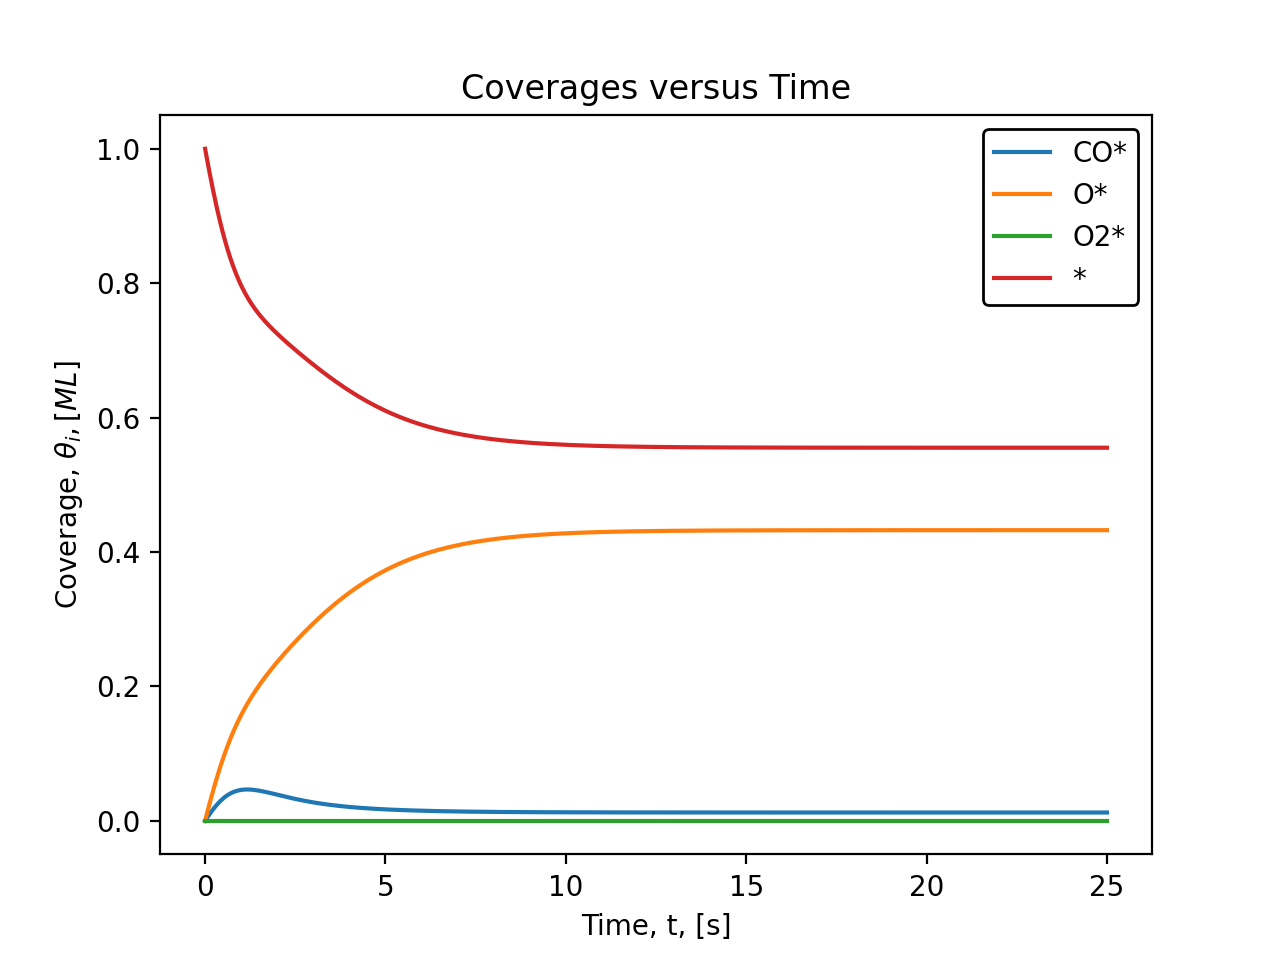

In [3]:
kfit1 = np.array([5.62922229e+06, 1.44144197e-08, 9.27331465e+06, 9.72747900e+03,
 4.23124465e+07, 4.62865632e+02, 7.34083737e+00, 2.56395440e+06])
fit.MKM.k = kfit1
sola1,solta1= fit.MKM.solve_coverage(plot=True) #Obtains the coverages(sol) with respect to time(solt) and plots them if plot=True (Note: Additional options can be set manually - See main.py for syntax)

<IPython.core.display.Javascript object>


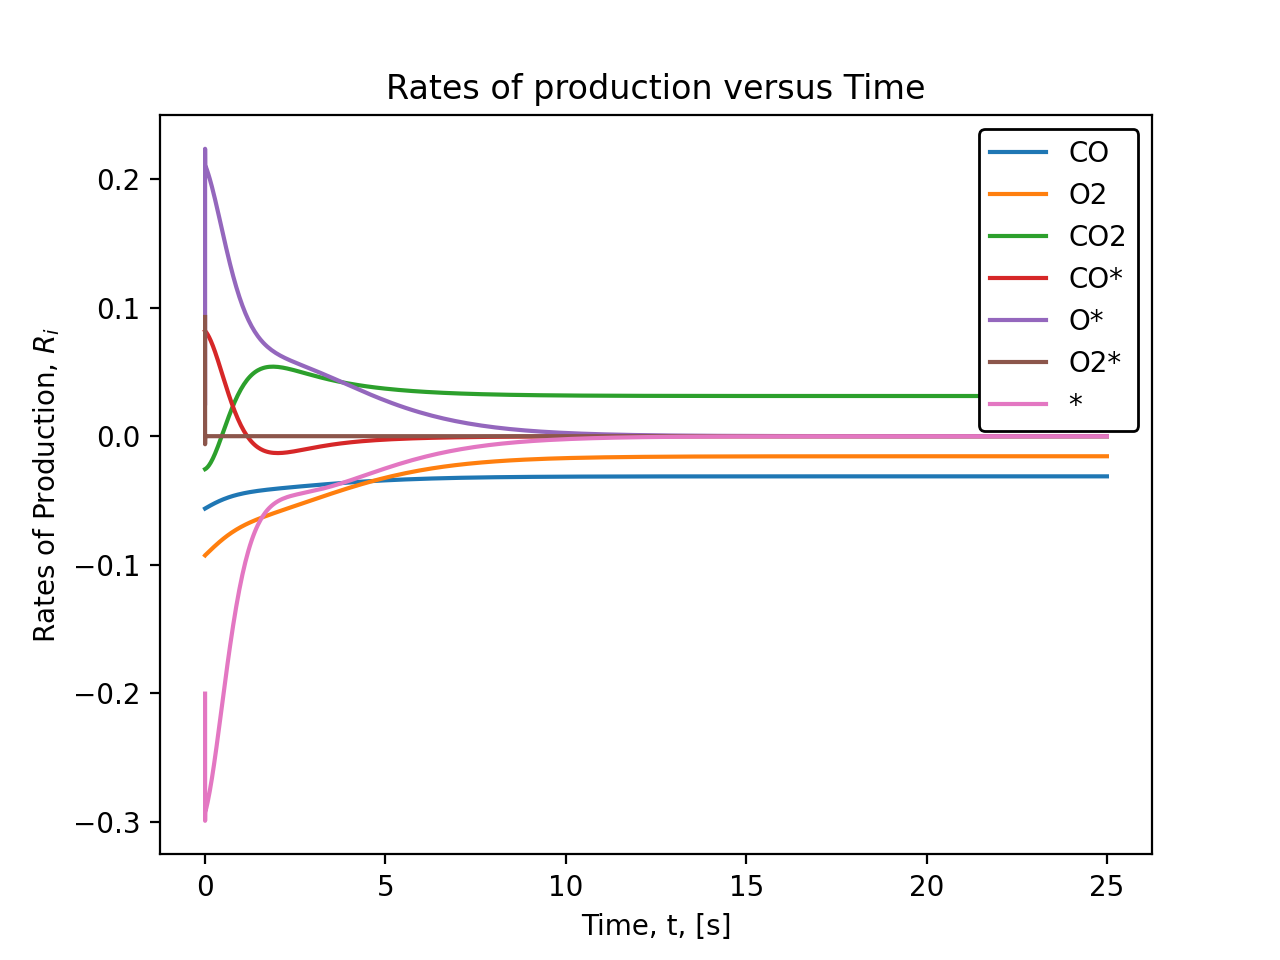

In [4]:
solb1,soltb1 = fit.MKM.solve_rate_production(plot=True)

### Comparing steady state rates of prod.

In [5]:
#From Input:
Inp = fit.Input.iloc[-1,-3:].to_numpy() # CO | O2 | CO2
print(Inp)

[-0.02115885 -0.02441406  0.02875434]


In [6]:
#From Simulation (With fitted rate constants)
RateVec = fit.MKM.get_SS_rates_production()[:len(fit.MKM.Pextract())]
print(RateVec)

[-0.03125226 -0.01562655  0.03125231]


In [7]:
#Calculating %difference
pd = np.empty(len(RateVec))
for i in np.arange(len(RateVec)):
    pd[i] = np.abs((Inp[i]-RateVec[i])/(Inp[i]))*100
    
print(pd)

[47.70296921 35.99365101  8.68726824]


### Degree of rate control

Original format:
$$X_{RC_i} = \frac{d ln(r)}{d ln k_i} $$

Simplified:

$$X_{RC_i}=\frac{r_{new_i} - r_o}{p_{inc}*r_o} $$

Note:

$r_{new_i}$ : The rate of the designated reaction i of whose rate constants where increased by $p_{inc}$

$p_{inc}$ : Percent increase applied to the rate constants of the designated rate being studied. (All other rate constants for the other reactions remain unchanged)

$r_o$ : The rate of reaction of the step being compared against (Usually the production or synthesis step)

In [8]:
fit.MKM.get_X_RC_SS(k_o_inp=kfit1)

[1.0925309417825846,
 -5.04128785807738,
 -4.999890596934406,
 0.009033208804604025]